# Counting the Bollworms
This notebook demonstrates the first step to automatic counting of Bollworms using images.

##### **Classfication of 2 types**: We will be using Fastai library+some heavy data augmentation using fastai Vision augmentation + densenet201 as a classification model. 
* Benefits: model is relatively easy to fine-tune for a new task while retaining the useful knowledge of the original classifier. 
*  Drawbacks: despite higher accuracy compared to the previous solution, this model is not perfect and could not be used in environments where high precision is important.

# 1- IMPORTS

In [1]:
pip install timm 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 4.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastai.vision.all import *
import timm
import warnings 
import gc
import inspect
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

#### Fix seed so we can reproduce our results

In [3]:
set_seed(21, reproducible=True)

#### Read files and label encode target value

In [4]:
train = pd.read_csv('/kaggle/input/wadhwani-ai-bollworm/Train.csv')
test=pd.read_csv('/kaggle/input/wadhwani-ai-bollworm/Test.csv')
files_dir = '/kaggle/input/wadhwani-ai-bollworm/images_resized'
def convert_str(x):
    if x =='pbw':
        return 1
    elif x=='abw':
        return 2
train['worm_type']=train['worm_type'].apply(convert_str)
train['worm_type']=train['worm_type'].fillna(0)

train['worm_type'] = train['worm_type'].astype('int')
train

,image_id_worm,worm_type,number_of_worms
0,id_0002ea6f15c7fa6f4c221783.jpg,1,51
1,id_0005ef295aafe6acc63587db.jpg,1,8
2,id_00084298dd030a500033ff78.jpg,0,0
3,id_00093f2c76f6488737325859.jpg,1,12
4,id_000b2e6c437c643f25d4a6c3.jpg,1,87
...,...,...,...
9895,id_ffe6e193dd78b7258d864f6b.jpg,2,5
9896,id_ffe98feb1e592e887b81c3f0.jpg,1,95
9897,id_ffef90ecf47baa38434f84fb.jpg,1,26
9898,id_fff06bb2e59bfce437ac9fc0.jpg,0,0


#### Creat dataloader and augmentations

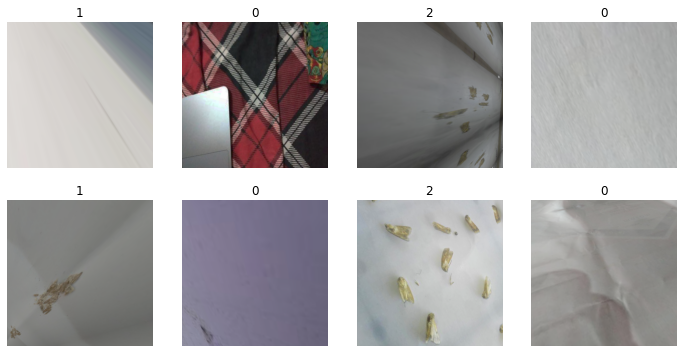

In [11]:
# Create the dataloaders


tfms=aug_transforms(size=500,do_flip=False, max_zoom=4, max_rotate=90,max_warp=1,flip_vert=True, max_lighting=0.4)
#train_rgb = train[~train.Image_id.str.contains('_rgn')] # Just the RGB images
dls = ImageDataLoaders.from_df(train, fn_col='image_id_worm', label_col='worm_type', 
                               folder='/kaggle/input/wadhwani-ai-bollworm/images_resized/images_resized/', item_tfms=Resize(500),
                               batch_tfms = tfms,
                               bs=8
                              )
dls.show_batch() # Note the augmentation applied to the images!

In [10]:
free_memory(dls)

#### Create usefull function to use in traning 

In [6]:
def free_memory(to_delete: list):
    calling_namespace = inspect.currentframe().f_back

    for _var in to_delete:
        calling_namespace.f_locals.pop(_var, None)
        gc.collect()
        torch.cuda.empty_cache()
        
class Log_loss(Callback):

  def on_epoch_begin(self, **kwargs):
    self.count, self.val = 0., 0.

  def on_batch_end(self, last_output, last_target, **kwargs):
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0)
        loss = F.cross_entropy(last_output, *last_target)
        
        self.val += last_target[0].size(0) * loss.detach().cpu()

  def on_epoch_end(self, last_metrics, **kwargs):
    "Set the final result in `last_metrics`."
    return add_metrics(last_metrics, self.val/self.count)

#### Define the model, choose the evaluation metrics and use lr_find methode to find the optimal Learning rate 

SuggestedLRs(valley=6.918309736647643e-06)

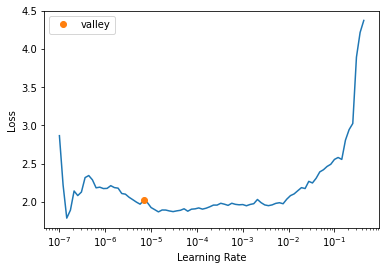

In [12]:
from fastai.metrics import accuracy,error_rate

learn = cnn_learner(dls,densenet201,metrics= [error_rate,accuracy])
learn.lr_find()

### We first fine_tune model for 3 epoches then unfreeze all weights except the last 5 fully dense layers who are already modified and retrain them with smaller LR 

In [6]:
learn.fine_tune(3,7e-06)
learn.freeze_to(-5)
learn.fit_one_cycle(3,1e-02)
#learn.save('densenet201_classification_3_epochs')

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

### Load saved model and make predicitons

In [8]:
learn=learn.load('/kaggle/input/models/densenet201_classification_3_epochs')
preds, _ = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities
preds.shape

### Finally, we create our submission file who will be delivered to the regression model

In [10]:
labels=['null','pbw','abw']
#test = pd.read_csv('sample_submission.csv')
test['label'] = np.argmax(preds, axis=-1)
test['label'] = test['label'].replace([0,1,2], labels)
test.to_csv("Submission.csv",index=False)
test.head()

,image_id_worm,label
0,id_00332970f80fa9a47a39516d.jpg,abw
1,id_0035981bc3ae42eb5b57a317.jpg,pbw
2,id_005102f664b820f778291dee.jpg,abw
3,id_0066456f5fb2cd858c69ab39.jpg,abw
4,id_007159c1fa015ba6f394deeb.jpg,null
